SONAR SPECTROGRAM CLASSIFICATION USING CNN AND GAN

Import Block

In [ ]:
import numpy as np #for creating sine wave,time signals and noise
import matplotlib.pyplot as plt #plotting spectogram
import os #creating files and saving files
import random #for data shuffling
from scipy.signal import spectrogram #spectrogram() converts sonar to 2d format
from PIL import Image  #loading,resizing,preprossessing the images

import tensorflow

functions to generate sonar signals

In [ ]:
def generate_sonar_signal(class_type,duration=0.2,fs=5000):
  t=np.linspace(0,duration,int(duration*fs),endpoint=False) # time array

  if class_type=='mine':
    freq=100+20+np.sin(2*np.pi*1*t)  # modulated freq
    signal= np.sin(2*np.pi*freq*t)+0.1*np.random.randn(len(t))  # add noise

  elif class_type=='fish':
    freq=300+50*np.sin(2*np.pi*0.5*t)  # fish freq pattern
    signal=np.sin(2*np.pi*freq*t)+0.2*np.random.randn(len(t)) # more noise

  elif class_type=='rock':
    freq=50  # steady low freq
    signal=0.6*np.sin(2*np.pi*freq*t)+0.05*np.random.randn(len(t))  # slight noise

  return signal,fs


def save_spectrogram(signal,fs,class_type,idx,base_dir='datasets'):
  f,t,sxx=spectrogram(signal,fs)  # convert to spectrogram
  plt.figure(figsize=(2,2)) # fixed image size
  plt.pcolormesh(t,f,sxx,shading='gouraud') # plot spectrogram
  plt.axis('off') # remove axes
  plt.tight_layout(pad=0)  # no padding


  path=os.path.join(base_dir,class_type)  # class folder path
  os.makedirs(path,exist_ok=True)  # create folder if needed

  filename=os.path.join(path,f"{class_type}_{idx:03d}.png")  # image name
  plt.savefig(filename,bbox_inches='tight',pad_inches=0)  # save image
  plt.close() # close plot

now generating images

In [ ]:
base_dir='datasets' # main dataset folder
classes=['fish','mine','rock']  # class labels

for cls in classes: # loop through each class
  for i in range(100):  # generate 100 samples per class
    signal,fs=generate_sonar_signal(cls)   # create synthetic sonar signal
    save_spectrogram(signal,fs,cls,i,base_dir)  # convert to spectrogram and save


view sample images from each class

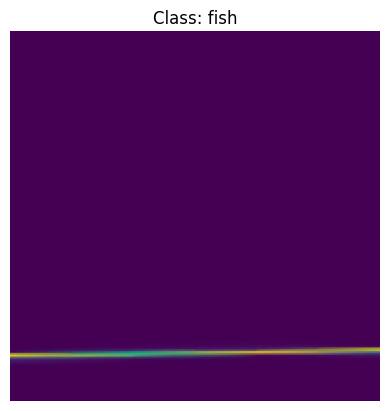

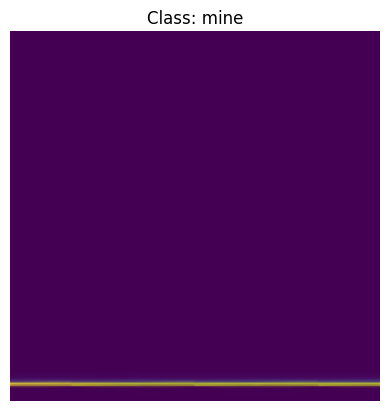

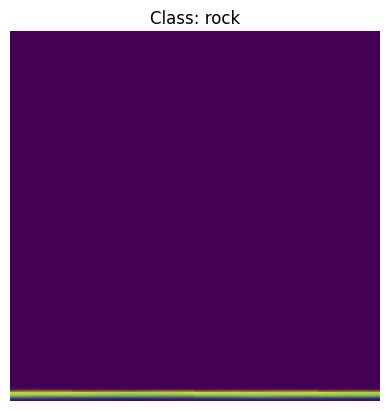

In [ ]:
base_dir = 'datasets' # root folder
classes = ['fish', 'mine', 'rock']  # class names

# Show 1 image from each class
for cls in classes:
    # Get the first image file in that class
    image_path = os.path.join(base_dir, cls, os.listdir(os.path.join(base_dir, cls))[0])  # first image path

    # Open and show the image
    img = Image.open(image_path)  # load image
    plt.imshow(img) # display image
    plt.title(f"Class: {cls}")  # show class label
    plt.axis('off') # hide axes
    plt.show()   # show plot

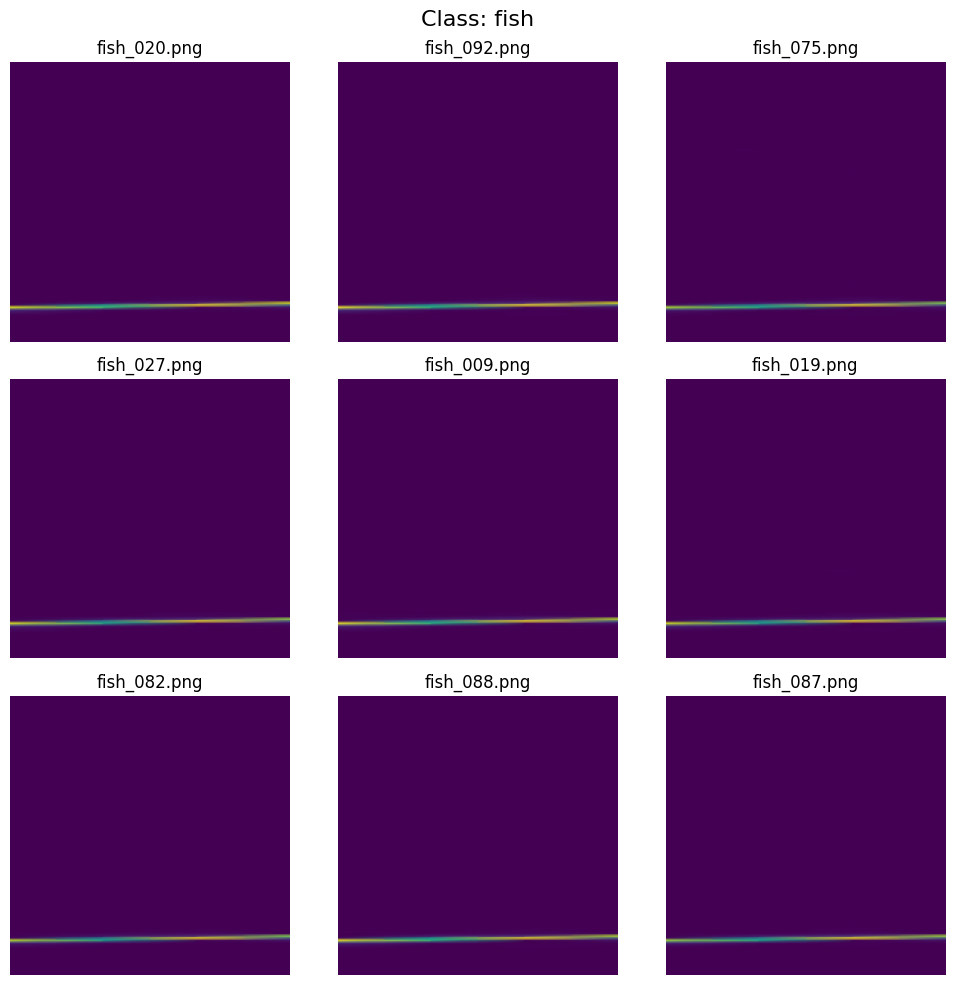

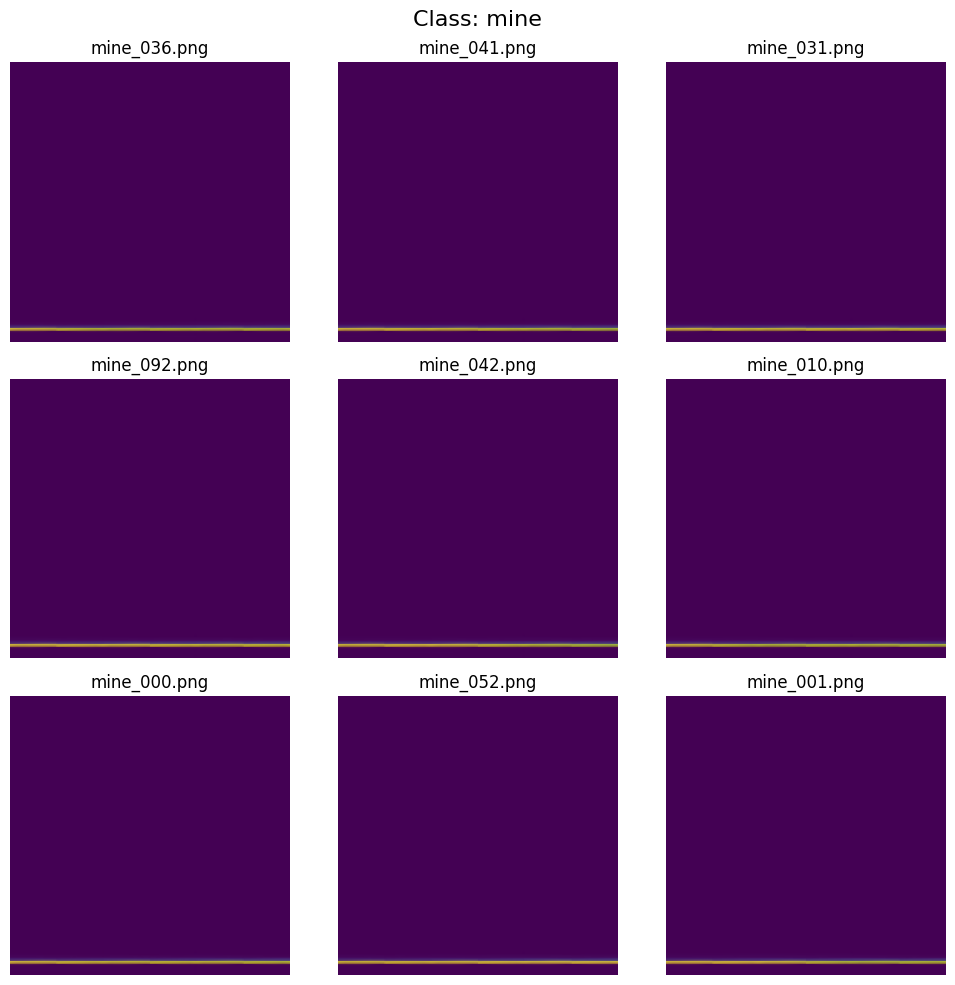

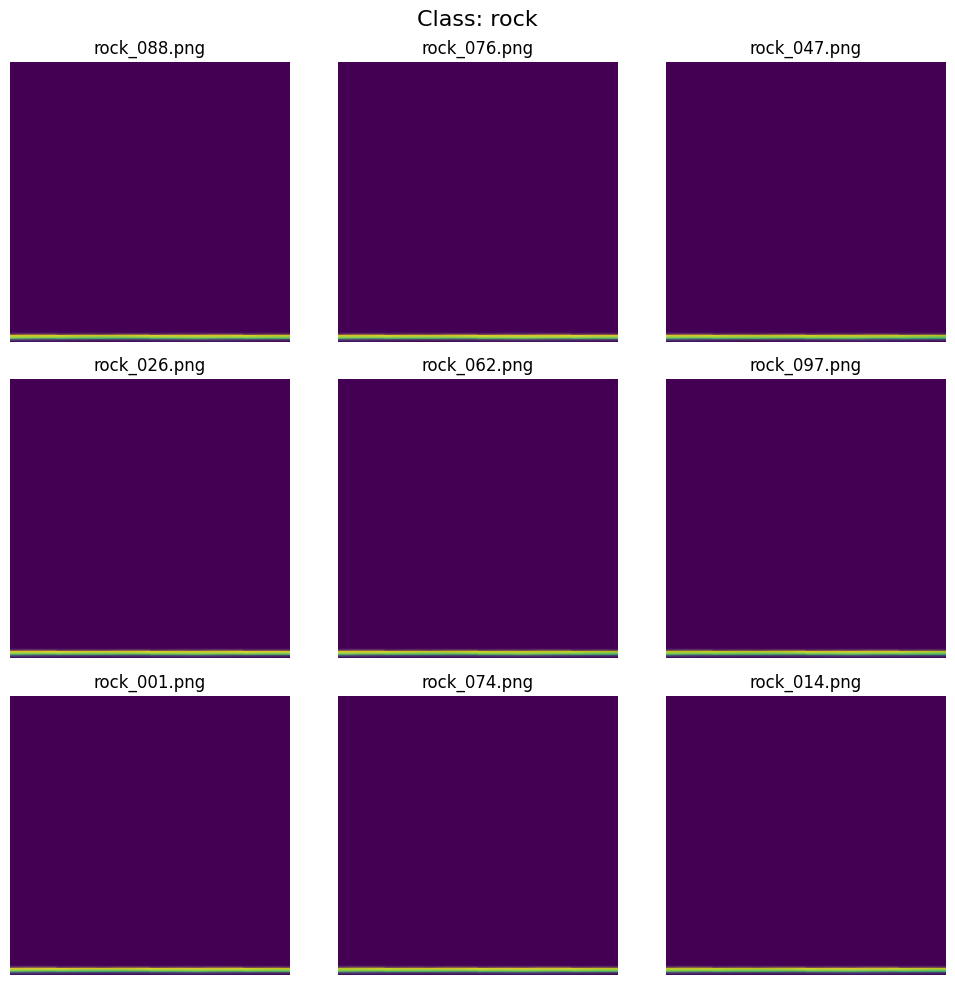

In [ ]:
def show_image_grid(class_name, base_dir='datasets', num_images=9):
    #build the path to image dir for given class name
    path = os.path.join(base_dir, class_name)

    #get list of img names in the dir (upto num_images)
    image_files = os.listdir(path)[:num_images]

    #create a new figure for plotting in the gird
    plt.figure(figsize=(10, 10))

    #loop through selected img files
    for i, img_file in enumerate(image_files):
        img_path = os.path.join(path, img_file)  # Full path
        img = Image.open(img_path)   # Open image
        plt.subplot(3, 3, i+1)  # 3x3 grid
        plt.imshow(img) # Show image
        plt.title(f"{img_file}")  # Title = filename
        plt.axis('off') # Hide axes
    plt.suptitle(f"Class: {class_name}", fontsize=16) # Class title
    plt.tight_layout()  # Adjust layout to prevent overlapping
    plt.show()

# Example usage
show_image_grid('fish')
show_image_grid('mine')
show_image_grid('rock')

building CNN model

In [ ]:
import tensorflow as tf  #DL libs to build and train neural networks
from tensorflow.keras.models import Sequential #linear stack of layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
#Conv2D: the core convolutional layer for extracting patterns from images (like edges in spectrograms).
#MaxPooling2D: downsampling layer — reduces the size while keeping key features.
#Flatten: flattens 2D features into 1D before passing to Dense layer.
#Dense: fully connected layer for decision making (e.g., classify between mine/fish/rock).
#Dropout: randomly turns off neurons during training to avoid overfitting — keeps the model general#
from tensorflow.keras.preprocessing.image import ImageDataGenerator #load resize augument images from folders
from tensorflow.keras import Input #for inpput layer

In [ ]:
model=Sequential()

#input layer
model.add(Input(shape=(128,128,3)))

#convo1
model.add(Conv2D(32,(3,3),activation='relu')) #learns basic feature like edges and shapes
model.add(MaxPooling2D((2,2)))

#convo2
model.add(Conv2D(64,(3,3),activation='relu')) #learns deeper features like textures and blobs
model.add(MaxPooling2D((2,2)))

#convo3
model.add(Conv2D(128,(3,3),activation='relu')) #learns high level features
model.add(MaxPooling2D((2,2)))

#flatten-> convert 3D to 1D for dense layer
model.add(Flatten())

#dense layer
model.add(Dense(128,activation='relu'))

#dropout->avoid overfitting by randomly turning off 50% neurons
model.add(Dropout(0.5))

#output layer->3 neurons for 3 classes softmax for class prediction
model.add(Dense(3,activation='softmax'))



complie the model

In [ ]:
model.compile(
    optimizer='adam', #adaptice learning
    loss='categorical_crossentropy', #for multi-class classification
    metrics=['accuracy']
)

split the data to traning_data 80% and validation_data 20%

In [ ]:
img_size=128

#rescaling to [0-255] to [0-1] and splitting data train data 80% and validation 20%
datagen=ImageDataGenerator(rescale=1./255,validation_split=0.2)

#load training data 80%
train_data=datagen.flow_from_directory(
    'datasets',
    target_size=(img_size,img_size),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)


#load validation data
val_data=datagen.flow_from_directory(
    'datasets',
    target_size=(img_size,img_size),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)


Found 240 images belonging to 3 classes.
Found 60 images belonging to 3 classes.


backup the data

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -r '/content/drive/MyDrive/Colab Notebooks/sonar_dataset_backup' datasets

In [ ]:
#verify
import os
os.listdir('datasets')

['mine', 'fish', 'rock']

training model

load model

In [ ]:
!cp -r '/content/drive/MyDrive/Colab Notebooks/sonar_dataset_backup' datasets

In [ ]:
!rm -r datasets/sonar_dataset_backup

rm: cannot remove 'datasets/sonar_dataset_backup': No such file or directory


In [ ]:
train_data.class_indices

{'fish': 0, 'mine': 1, 'rock': 2}

In [ ]:
from re import VERBOSE
history=model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    verbose=1
)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.4830 - loss: 1.0330 - val_accuracy: 1.0000 - val_loss: 0.4714
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.8453 - loss: 0.3983 - val_accuracy: 1.0000 - val_loss: 0.0395
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.9948 - loss: 0.0564 - val_accuracy: 1.0000 - val_loss: 7.9081e-05
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 930ms/step - accuracy: 1.0000 - loss: 0.0026 - val_accuracy: 1.0000 - val_loss: 1.6014e-06
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 1.0000 - val_loss: 2.9416e-05
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 1.0000 - loss: 2.7689e-04 - val_accuracy: 1.0000 - val_loss: 1.1172e-05
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 1.0000 - loss: 4.5146e-04 - val_accuracy: 1.0000 - val_loss: 1.5895e-07
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 1.0000 - loss: 1.0445e-05 - val_accuracy: 1.0000 - val_l

# New Section

save trained model

In [ ]:
model.save('/content/drive/MyDrive/sonar_cnn_model.keras')

quick checks for being perfect overfitting or underfitting?

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
Predicted class: rock


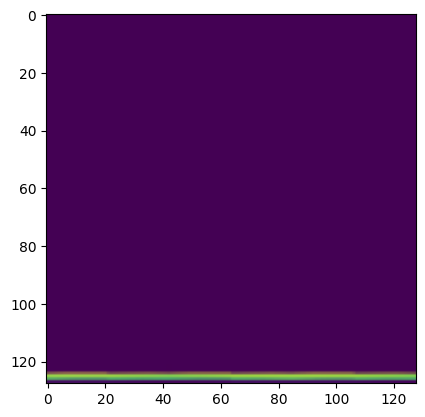

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

IMG_HEIGHT=128
IMG_WIDTH=128

image_path = '/content/datasets/rock/rock_081.png'  # Replace with the path to your image

img = image.load_img('/content/datasets/rock/rock_081.png', target_size=(IMG_HEIGHT, IMG_WIDTH))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)
plt.imshow(img) # display image

prediction = model.predict(img_array)
class_names = ['fish', 'mine', 'rock']  # Adjust accordingly
print("Predicted class:", class_names[np.argmax(prediction)])

prediction probabilities

In [ ]:
for i,class_names in enumerate(class_names):
  print(f"{class_names}:{prediction[0][i]*100:.2f}%")

fish:0.00%
mine:0.00%
rock:100.00%


gen more fish sonar imgs with variations

In [ ]:
def generate_sonar_signal(class_type, variation=1, duration=0.2, fs=5000):
    t = np.linspace(0, duration, int(duration * fs), endpoint=False)

    if class_type == 'fish':
        if variation == 1:
            freq = 300 + 50 * np.sin(2 * np.pi * 0.5 * t)
            signal = np.sin(2 * np.pi * freq * t) + 0.1 * np.random.randn(len(t))
        elif variation == 2:
            freq = 250 + 100 * np.sin(2 * np.pi * 4 * t)
            signal = np.sin(2 * np.pi * freq * t) + 0.2 * np.random.randn(len(t))
        elif variation == 3:
            f1 = 280 + 30 * np.sin(2 * np.pi * 0.7 * t)
            f2 = 320 + 40 * np.cos(2 * np.pi * 1.2 * t)
            f3 = 290 + 35 * np.sin(2 * np.pi * 0.3 * t)
            signal = (np.sin(2 * np.pi * f1 * t) +
                      np.sin(2 * np.pi * f2 * t) +
                      np.sin(2 * np.pi * f3 * t)) / 3
            signal += 0.15 * np.random.randn(len(t))
    elif class_type == 'mine':
        freq = 100 + 20 * np.sin(2 * np.pi * 1 * t)
        signal = np.sin(2 * np.pi * freq * t) + 0.1 * np.random.randn(len(t))
    elif class_type == 'rock':
        freq = 50
        signal = 0.6 * np.sin(2 * np.pi * freq * t) + 0.05 * np.random.randn(len(t))

    return signal, fs

In [ ]:
import random
for cls in ['fish', 'mine', 'rock']:
    for i in range(100):
        if cls == 'fish':
            variation = random.randint(1, 3)
            signal, fs = generate_sonar_signal(cls, variation=variation)
        else:
            signal, fs = generate_sonar_signal(cls)
        save_spectrogram(signal, fs, cls, i, base_dir)

NameError: name 'save_spectrogram' is not defined

In [1]:
!git --version  # should return version

git version 2.34.1


In [12]:
!ls "/content/drive/MyDrive/Colab Notebooks/" | grep ".ipynb"

Copy of facial_expression_recognition.ipynb
Copy of OCR.ipynb
Copy of sonar spectrogram classifier.ipynb
OCR.ipynb
sonar spectrogram classifier.ipynb


In [2]:
!git clone https://github.com/tejonish/sonar_classification.git

Cloning into 'sonar_classification'...
